# Minesweeper Bot Analysis
Primarily an analysis of my probabilistic strategy.

Data collection overview:
- 9x9 grid, varying the number of mines from 0 to 81. 
- 1000 trials per distinct density (so 82000 games simulated).

Insights:
1. Runtime by density
2. Win rate by density
3. Turns taken to win by density
    - How many tiles are cleared?
4. Turns taken to lose by density
    - How many tiles are cleared?
    - How many tiles are left?

Import dependencies

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

Read data

In [85]:
df = pd.read_csv("../data/test.csv")
df

,numRows,numColumns,initialDensity,numMines,status,numMoves,numTilesCleared,elapsedMillis
0,9,9,0.0,0,WIN,1,81,7
1,9,9,0.0,0,WIN,1,81,0
2,9,9,0.0,0,WIN,1,81,1
3,9,9,0.0,0,WIN,1,81,1
4,9,9,0.0,0,WIN,1,81,1
...,...,...,...,...,...,...,...,...
81995,9,9,1.0,81,LOSE,1,0,1
81996,9,9,1.0,81,LOSE,1,0,0
81997,9,9,1.0,81,LOSE,1,0,0
81998,9,9,1.0,81,LOSE,1,0,0


### Some helper functions

Recall the densities of the different difficulties:
- $\rho_\text{easy} = 0.1234567901$.
- $\rho_\text{medium} = 0.15625$.
- $\rho_\text{hard} = 0.20625$.
- $\rho_\text{expert} = 0.25$.

<u>Main idea:</u> We can use the 9x9 board data to approximate the win rates of the probabilistic algorithm for the different difficulty games 

In [86]:
densities = {
    "easy": 0.1234567901, 
    "medium": 0.15625, 
    "hard": 0.20625, 
    "expert": 0.25
}

Function to get the rows of a DataFrame with intialDensity = density ± epsilon

In [87]:
def has_density(df, density, epsilon = 0.005):
    return df[(df["initialDensity"] >= (density - epsilon)) & (df["initialDensity"] <= (density + epsilon))]

Function that returns a dataframe with rows with all initialDensity = density ± epsilon for each density in a passed in dictionary of difficulty:density mapping

In [88]:
def has_densities(df, densities = densities, epsilon = 0.005):
    filtered_rows = []
    for difficulty, density in densities.items():
        filtered_rows.append(has_density(df, density, epsilon).assign(approxDifficulty = difficulty))
    return pd.concat(filtered_rows, ignore_index = True)

Function that returns a DataFrame with a new column which holds the normalized values of a given column, based on a known "key" cell, e.g. difficulty = "easy". Thus, we can do something like normalize runtime based on the runtime of the "easy" difficulty.

This gives us insight into things like how much slower/faster the runtime is relative to the easy difficulty.

In [89]:
def normalize_column_by_key(df, column_to_normalize: str, key_column: str = "approxDifficulty", key_value: str = "easy"):
    df_norm = df.copy()
    df_norm[column_to_normalize + "Normalized"] = df_norm[column_to_normalize] / df_norm.loc[df[key_column] == key_value, column_to_normalize].values[0]
    return df_norm

Similar, but instead we normalize by the minimum value in the column we are normalizing

In [127]:
def normalize_column_by_min(df, column_to_normalize: str):
    return normalize_column_by_key(df, column_to_normalize, column_to_normalize, df[column_to_normalize].min())


Function that:
1. Finds rows that have given density values
2. Normalizes by a given "key"

In [128]:
def approx_difficulty_and_normalize_column_by_key(df, column_to_normalize, key_column: str = "approxDifficulty", key_value: str = "easy"):
    return df.pipe(has_densities).pipe(normalize_column_by_key, column_to_normalize, key_column, key_value)

In [129]:
def approx_difficulty_and_normalize_column_by_min(df, column_to_normalize):
    return df.pipe(has_densities).pipe(normalize_column_by_min, column_to_normalize)

Function to plot a column by density

In [130]:
def plot_column_by_density(df, column, y_label):
    plt.plot(df["initialDensity"], df[column])
    plt.xlabel("Density")
    plt.ylabel(y_label)
    plt.title(y_label + " vs Density")
    plt.show()

### 1. Win rate

Function to calculate the win rate per group

In [131]:
def win_rate(group):
    return pd.Series({"winRate": len(group[group["status"] == "WIN"]) / len(group["status"])})

Group by initial density and then find the win rate by density by applying the above function

In [132]:
winrate_df = df.groupby(["initialDensity"]).apply(lambda x : win_rate(x))["winRate"].reset_index()

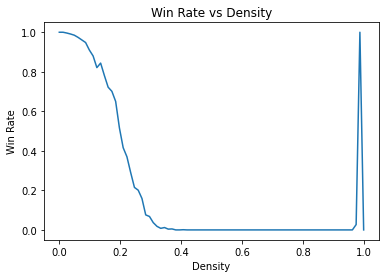

In [133]:
plot_column_by_density(winrate_df, "winRate", "Win Rate")

There is a spike at numMines = 80 because we are guaranteed to start on a non-mine, and this is the only non-mine there is.

Here we see the win rates for the approximate difficulties

In [134]:
approx_difficulty_and_normalize_column_by_key(winrate_df, "winRate")

,initialDensity,winRate,approxDifficulty,winRateNormalized
0,0.123457,0.821,easy,1.000000
1,0.160494,0.722,medium,0.879415
2,0.209877,0.416,hard,0.506699
3,0.246914,0.215,expert,0.261876


Normalizing by the minimum might give us a better idea:

In [135]:
approx_difficulty_and_normalize_column_by_min(winrate_df, "winRate")

,initialDensity,winRate,approxDifficulty,winRateNormalized
0,0.123457,0.821,easy,3.818605
1,0.160494,0.722,medium,3.358140
2,0.209877,0.416,hard,1.934884
3,0.246914,0.215,expert,1.000000


Relative to expert difficulty, we win around 3.8x as much in easy, 3.4x in medium, and 1.9x in hard.

Let's try to find the maximal density such that winRate > 0

In [136]:
winrate_df[winrate_df["winRate"] > 0].tail()

,initialDensity,winRate
29,0.358025,0.004
30,0.370370,0.005
33,0.407407,0.001
79,0.975309,0.027
80,0.987654,1.000


So, we see that 0.4075 and 0.9753 are the maximal densities such that we can win (besides the trivial 80)

### 2. Runtime

In [137]:
mean_runtime_df = df.groupby(["initialDensity"]).mean("elapsedMillis")["elapsedMillis"].reset_index()

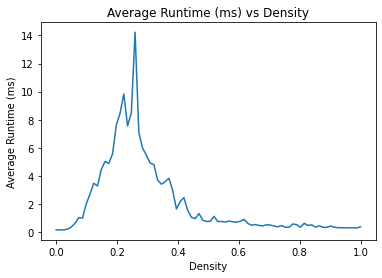

In [138]:
plot_column_by_density(mean_runtime_df, "elapsedMillis", "Average Runtime (ms)")

Normalized runtime by the runtime of the "easy" approximate difficulty

In [139]:
approx_difficulty_and_normalize_column_by_key(mean_runtime_df, "elapsedMillis")

,initialDensity,elapsedMillis,approxDifficulty,elapsedMillisNormalized
0,0.123457,3.469,easy,1.000000
1,0.160494,5.025,medium,1.448544
2,0.209877,8.452,hard,2.436437
3,0.246914,8.474,expert,2.442779


So, relative to the easy difficulty, medium games take 1.4 times longer, hard and expert both take around 2.4 times longer.

### 3. Number of moves

Mean turns of all games

In [140]:
mean_turns_df = df.groupby(["initialDensity"]).mean("numMoves")["numMoves"].reset_index()

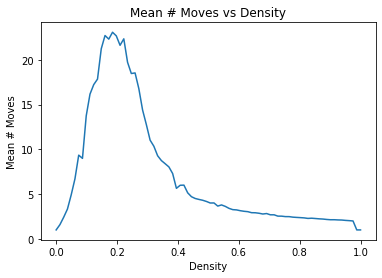

In [141]:
plot_column_by_density(mean_turns_df, "numMoves", "Mean # Moves")

Normalized data

In [142]:
approx_difficulty_and_normalize_column_by_key(mean_turns_df, "numMoves")

,initialDensity,numMoves,approxDifficulty,numMovesNormalized
0,0.123457,17.228,easy,1.000000
1,0.160494,22.710,medium,1.318203
2,0.209877,21.618,hard,1.254818
3,0.246914,18.466,expert,1.071860


We see that medium difficulty plays 1.32x more moves than easy difficulty. Expert difficulty has about the same mean number of moves (not accounting for win/lose)

#### Any difference between winners and losers?

##### Mean turns of winners

In [143]:
mean_turns_winners = mean_turns_df = df[df["status"] == "WIN"].groupby(["initialDensity"]).mean("numMoves")["numMoves"].reset_index()

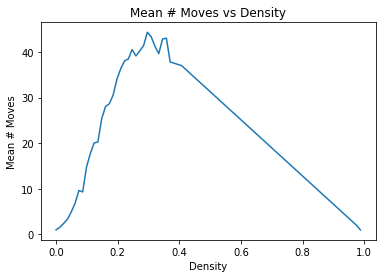

In [144]:
plot_column_by_density(mean_turns_winners,"numMoves", "Mean # Moves")

In [147]:
approx_difficulty_and_normalize_column_by_key(mean_turns_winners, "numMoves")

,initialDensity,numMoves,approxDifficulty,numMovesNormalized
0,0.123457,20.034105,easy,1.000000
1,0.160494,28.006925,medium,1.397962
2,0.209877,36.310096,hard,1.812414
3,0.246914,40.516279,expert,2.022365


It takes around twice as many moves to win a hard and expert game compared to an easy game.

##### Mean turns of losers

In [145]:
mean_turns_losers = mean_turns_df = df[df["status"] == "LOSE"].groupby(["initialDensity"]).mean("numMoves")["numMoves"].reset_index()

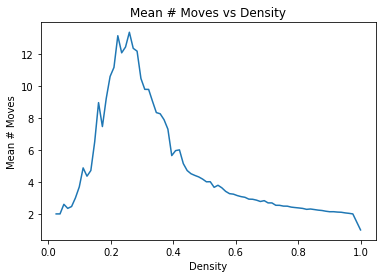

In [146]:
plot_column_by_density(mean_turns_losers,"numMoves", "Mean # Moves")

In [148]:
approx_difficulty_and_normalize_column_by_key(mean_turns_losers, "numMoves")

,initialDensity,numMoves,approxDifficulty,numMovesNormalized
0,0.123457,4.357542,easy,1.000000
1,0.160494,8.953237,medium,2.054653
2,0.209877,11.152397,hard,2.559332
3,0.246914,12.426752,expert,2.851780


Compared to easy difficulty, on average, there are 2.1x as many moves until you lose in medium, 2.6 in hard, and 2.9x in expert. Basically, on losing games, the harder the game gets, the more rounds you play until you lose.